<a href="https://colab.research.google.com/github/Romain-MARRION/Portfolio/blob/main/final_porjetct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Flatten, Dense, Dropout

In [2]:
SEED=42

In [3]:
train_dataset, validation_dataset , test_dataset = tfds.load(
    'ColorectalHistology', 
    shuffle_files=True,
    read_config = tfds.ReadConfig(shuffle_seed=SEED),
    as_supervised=True,
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incomplete6NV38Y/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


all the same lenght and values between 0 and 255

In [4]:
for element in train_dataset.take(3):
    print(element)

(<tf.Tensor: shape=(150, 150, 3), dtype=uint8, numpy=
array([[[238, 211, 226],
        [232, 205, 220],
        [233, 210, 230],
        ...,
        [242, 242, 240],
        [242, 241, 239],
        [244, 243, 241]],

       [[225, 213, 223],
        [223, 211, 221],
        [225, 208, 216],
        ...,
        [243, 242, 240],
        [243, 242, 240],
        [244, 243, 241]],

       [[225, 209, 222],
        [228, 212, 225],
        [230, 214, 224],
        ...,
        [243, 242, 240],
        [243, 242, 240],
        [244, 243, 241]],

       ...,

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[239, 243, 244],
        [239, 243, 244],
        [239, 243, 244],
        ...,
        [241, 241, 2

In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
num_classes=8

In [6]:
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
image_batch, label_batch = next(iter(train_dataset))
image_batch.shape, label_batch.shape


(TensorShape([32, 150, 150, 3]), TensorShape([32]))

In [24]:
model=Sequential(
    [
        Convolution2D(32, (3 ,3), input_shape=(150, 150, 3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Convolution2D(32, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Convolution2D(32, (3 ,3),padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64,activation='relu'),
        Dense(activation='softmax', units=num_classes)
    ]
)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 32)      

In [26]:
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [27]:
history =model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
94/94 [==============================] - 3s 23ms/step - loss: 7.6128 - accuracy: 0.3890 - val_loss: 1.2709 - val_accuracy: 0.4930
Epoch 2/10
94/94 [==============================] - 2s 20ms/step - loss: 0.9969 - accuracy: 0.5590 - val_loss: 0.8566 - val_accuracy: 0.6380
Epoch 3/10
94/94 [==============================] - 2s 21ms/step - loss: 0.8312 - accuracy: 0.6330 - val_loss: 0.8341 - val_accuracy: 0.6520
Epoch 4/10
94/94 [==============================] - 2s 20ms/step - loss: 0.7552 - accuracy: 0.6743 - val_loss: 0.8589 - val_accuracy: 0.6140
Epoch 5/10
94/94 [==============================] - 2s 20ms/step - loss: 0.6367 - accuracy: 0.7207 - val_loss: 0.9073 - val_accuracy: 0.6100
Epoch 6/10
94/94 [==============================] - 2s 20ms/step - loss: 0.5895 - accuracy: 0.7587 - val_loss: 1.0879 - val_accuracy: 0.5480
Epoch 7/10
94/94 [==============================] - 2s 21ms/step - loss: 0.4950 - accuracy: 0.8057 - val_loss: 1.1741 - val_accuracy: 0.6040
Epoch 8/10
94

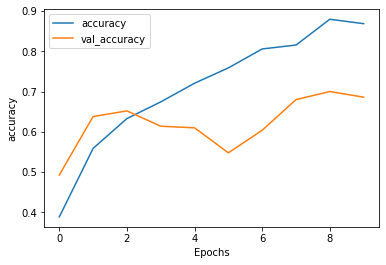

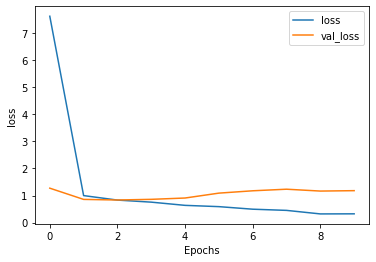

In [28]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")